In [1]:
# from google.colab import drive
from transformers import ViTFeatureExtractor, ViTForImageClassification, AdamW, get_scheduler
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
import numpy as np
import pandas as pd
import os
import torch
from PIL import Image
import torch
import datasets

C:\Users\TECHISTAN\anaconda3\envs\JamalDR\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

# Update the path to your dataset in your Google Drive
google_drive_path = './Dataset'  # Update with your dataset path

# Check if the directory exists
if not os.path.exists(google_drive_path):
    raise FileNotFoundError(f"The directory {google_drive_path} does not exist.")

# List subdirectories (classes) in the dataset path
subdirectories = sorted([d for d in os.listdir(google_drive_path) if os.path.isdir(os.path.join(google_drive_path, d))])

# Print the list of subdirectories
print("Subdirectories (Classes):", subdirectories)


Subdirectories (Classes): ['Aakefa Qaiser', 'Aaminah Qaiser', 'Abdur Rehman', 'Anusha Hamza', 'Ariba Yasmeen', 'Asher Hussain Rizvi', 'Bazil Bashir Faridi', 'Ebad Ali', 'Farah Hussain', 'Farhana Qaiser', 'Haseeb Shabbir', 'Laiba Azam', 'Malaika Ali', 'Marium Rizvi', 'Muhammad Ali Rizvi', 'Rameez Khan', 'Shagufta Aleem', 'Shaheer Ali Agha', 'Ushna Hamza', 'Usman Rizvi']


In [3]:
train_dataset = datasets.load_dataset("imagefolder", data_dir=google_drive_path)

Resolving data files: 100%|███████████████████████████████████████████████████| 35135/35135 [00:00<00:00, 72207.80it/s]


In [4]:
print(train_dataset["train"][0])

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x21EE9757910>, 'label': 0}


In [5]:
id2label = {k:v for k,v in enumerate(subdirectories)}
label2id = {v:k for k,v in enumerate(subdirectories)}

In [6]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224', do_rescale=False, cache_dir="models")

C:\Users\TECHISTAN\anaconda3\envs\JamalDR\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [7]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    # RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)
# Define the ImageProcessor class
class ImageProcessor:
    def __init__(self, image_mean, image_std, size):
        self.image_mean = image_mean
        self.image_std = image_std
        self.size = size

# Define image_processor with appropriate values
image_mean = [0.485, 0.456, 0.406]
image_std = [0.229, 0.224, 0.225]
image_size = {"height": 224, "width": 224}  # Example size, adjust as needed

# Instantiate the ImageProcessor object
image_processor = ImageProcessor(image_mean, image_std, image_size)

# Now you can use image_processor in your code
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

# normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
# if "height" in image_processor.size:
#     size = (image_processor.size["height"], image_processor.size["width"])
#     crop_size = size
#     max_size = None
# elif "shortest_edge" in image_processor.size:
#     size = image_processor.size["shortest_edge"]
#     crop_size = (size, size)
#     max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            # RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [8]:
splits = train_dataset["train"].train_test_split(test_size=0.2)
train_dataset = splits['train']
val_dataset = splits['test']

In [9]:
train_dataset.set_transform(preprocess_train)
val_dataset.set_transform(preprocess_val)

In [10]:
print(train_dataset[0])

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x21EFF8DB4C0>, 'label': 6, 'pixel_values': tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         ...,
         [ 2.2318,  2.2318,  2.2489,  ..., -1.1932, -1.0562, -0.8507],
         [ 2.1975,  2.1975,  2.2147,  ..., -0.9705, -0.7650, -0.4739],
         [ 1.9920,  2.1290,  2.1975,  ..., -0.6965, -0.5253, -0.4397]],

        [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         ...,
         [ 2.4286,  2.4111,  2.3936,  ..., -0.9678, -0.8102, -0.6001],
         [ 2.3761,  2.3761,  2.3936,  ..., -0.7402, -0.5301, -0.2325],
         [ 2.1485,  2.2885,  2.3585,  ..., -0.4601, -0.2850, -0.1975]],

In [11]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224',
                                                  num_labels=len(subdirectories),
                                                id2label=id2label,
                                                label2id=label2id,
                                                ignore_mismatched_sizes=True,
                                               cache_dir="models")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([20, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [13]:
!pip install accelerate -U


In [14]:
from transformers import TrainingArguments, Trainer

batch_size = 16
epochs = 20
checkpoints_path = './Model_Checkpoint'  # Set your Desired Location for the checkpoints
args = TrainingArguments(
    report_to='none',
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    output_dir=checkpoints_path,
    num_train_epochs=epochs,
    warmup_ratio=0.1,
    logging_steps=10,
    save_steps=100, # set yourself
    eval_steps=150, # set yourself
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

C:\Users\TECHISTAN\anaconda3\envs\JamalDR\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
from datasets import load_metric

metric = load_metric("accuracy")

C:\Users\TECHISTAN\AppData\Local\Temp\ipykernel_8520\1780215247.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [16]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [17]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [18]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)


In [19]:
train_results = trainer.train() #give string for the path if checkpoints are saved in the directory otherwise leave, example is mentioned below
# train_results = trainer.train(checkpoints_path)

Epoch,Training Loss,Validation Loss,Accuracy
0,1.701200,1.336872,0.594422
1,1.178200,0.705276,0.776007
2,0.887100,0.463342,0.851146
4,0.622100,0.279918,0.905650
5,0.555300,0.225886,0.922300
6,0.479300,0.174858,0.938381
8,0.396600,0.149809,0.946350
9,0.458700,0.122634,0.958588
10,0.423700,0.124758,0.954319
12,0.347200,0.120811,0.954319


In [20]:
saved_model_path = './Saved_Model'
saved_model_state_path = './Saved_Model_States'
trainer.save_model(saved_model_path) #Saved Model Path
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =       19.9886
  total_flos               = 40554845138GF
  train_loss               =         0.611
  train_runtime            =    2:54:26.79
  train_samples_per_second =        53.709
  train_steps_per_second   =         0.839


In [29]:
model_path = './Saved_Model'  # Update with the path to your saved model

model = ViTForImageClassification.from_pretrained(model_path).to("cuda")


image = Image.open(r"D:\deepwriter\Dataset\Rameez Khan\RK_A1_P_256_1536.png")

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])
input_image = transform(image)

# Perform inference
with torch.no_grad():
    inputs = input_image.unsqueeze(0).to("cuda") # Add batch dimension
    outputs = model(inputs)
    
predicted_class_idx = torch.argmax(outputs.logits).item()
predicted_label = id2label[predicted_class_idx]

In [30]:
predicted_label

'Rameez Khan'

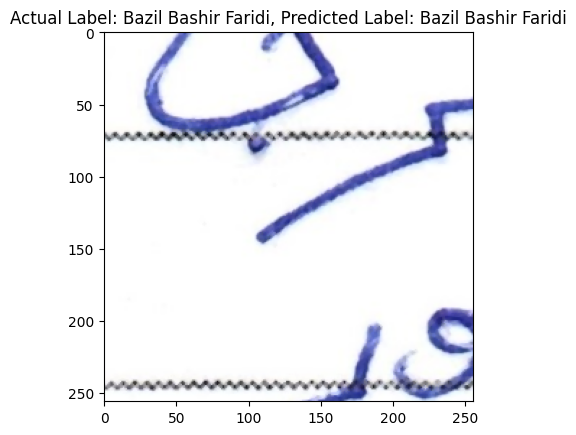

In [28]:
import os
import random
from PIL import Image
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Load the saved model
model_path = './Saved_Model'  # Update with the path to your saved model
model = ViTForImageClassification.from_pretrained(model_path)

# Set the model to evaluation mode
model.eval()

# Get a list of all image files in your dataset
dataset_path = './Dataset'  # Update with the path to your dataset
image_files = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            image_files.append(os.path.join(root, file))

# Select a random image from the list
random_image_path = random.choice(image_files)

# Open the selected image
image = Image.open(random_image_path)

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])
input_image = transform(image)

# Perform inference
with torch.no_grad():
    inputs = input_image.unsqueeze(0)  # Add batch dimension
    outputs = model(inputs)

# Get the predicted label
predicted_class_idx = torch.argmax(outputs.logits).item()
predicted_label = id2label[predicted_class_idx]

# Display the image
plt.imshow(image)
plt.title(f"Actual Label: {os.path.basename(os.path.dirname(random_image_path))}, Predicted Label: {predicted_label}")
plt.show()


